## 时间序列分析

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# from deteutil.relativedelta import relativedelta # 日期数据处理
from scipy.optimize import minimize  # 优化函数

import statsmodels.formula.api as smf # 数理统计
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error

### 以真实手游数据为例，来看玩家每小时观看的广告量和每天的游戏币消费情况

In [14]:
ads = pd.read_csv('ads.csv', index_col='Time', parse_dates=['Time'])
currency = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])

In [15]:
ads

Ads
Time                       
2017-09-13 00:00:00   80115
2017-09-13 01:00:00   79885
2017-09-13 02:00:00   89325
2017-09-13 03:00:00  101930
2017-09-13 04:00:00  121630
...                     ...
2017-09-21 19:00:00  155890
2017-09-21 20:00:00  123395
2017-09-21 21:00:00  103080
2017-09-21 22:00:00   95155
2017-09-21 23:00:00   80285

[216 rows x 1 columns]

In [17]:
currency

GEMS_GEMS_SPENT
Time                       
2017-05-01          1199436
2017-05-02          1045515
2017-05-03           586111
2017-05-04           856601
2017-05-05           793775
...                     ...
2018-02-20          2166449
2018-02-21          1552313
2018-02-22          2175548
2018-02-23          2122606
2018-02-24          1756394

[300 rows x 1 columns]

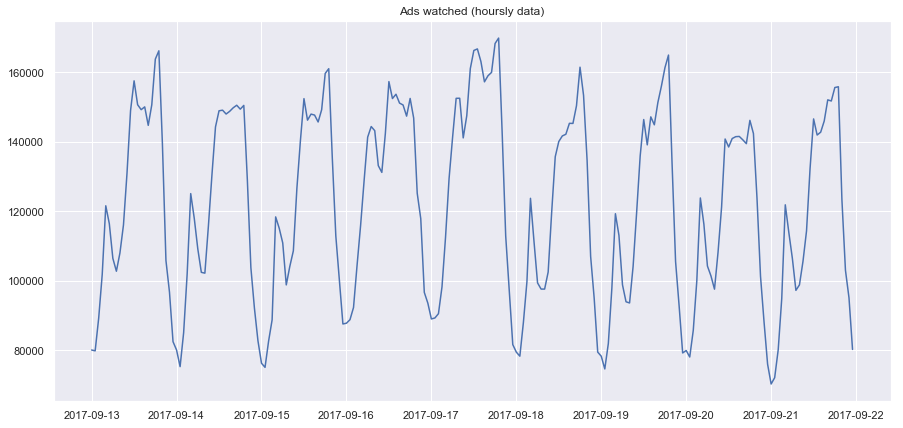

In [16]:
# 玩家在2017-9-13到2017-9-22十天内每小时广告观看量折线图

plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hoursly data)')
plt.grid(True)
plt.show()

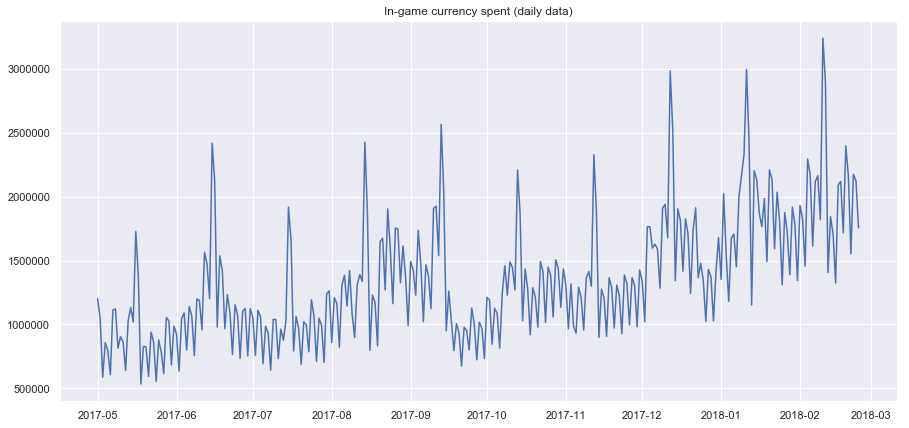

In [18]:
# 玩家在2017-05 到2018-03十一个月内，每天游戏币消费图

plt.figure(figsize=(15,7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

### 预测评估指标

1. R-squared：表示确定系数，描述模型的泛化能力，sklearn.metrics.r2_score

2. Mean Absolute Error: 平均绝对损失，一种预测值和真实值之间的度量标准 sklearn.metrics.mean_absolut_error
    
3. Median Absolute Error: 绝对损失的中位数，抗干扰能力强，对于有异常点的数据集鲁棒性比较好 sklearn.metrics.median_absolute_error

4. Mean Squared Error: 均方差损失，对于真实值和预测值偏差较大的样本点给予更高(平方)的惩罚 sklearn.metrics.mean_squared_error

5. Mean Squared Loarithmic Error: 均方对数误差，形式和MSE相似，只是计算的真实值的自然对数与预测值的自然对数之差的平方，通常适用于target有指数趋势 sklearn.metrics.mean_squared_log_error

6. Mean Absolute Percentage Error: 作用和MAE一样，只不过是以百分比的形式，用来解释模型的质量，但是在sklearn中没有这个函数接口


In [139]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 移动、平滑、评估

#### moving average

In [21]:
# 假设未来某个值的预测，取决于它前面n个数的平均值，因此用 moving average 作为target的值

def moving_average(series, n):
    return np.average(series[-n:])


moving_average(ads, 24)  # 对过去24小时的广告浏览量的预测

# 但是不适合进行长期预测

116805.0

移动平均还可以对原始时间序列数据进行平滑处理，以找到数据的变化趋势

pandas 提供了一个接口 DataFrame.rolling(window).mean()，window的值越大，意味着变化趋势会越平滑，对于噪音点很多的数据集（尤其是金融数据），使用这个接口，有助于探测到实际数据中存在的共性。

In [36]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_abnormalies=False):
    """
    series: dataframe with timeseries
    window: rolling window size
    plot_intervals: show confidence intervals
    plot_anomalies: show anomalies
    """
    rolling_mean = series.rolling(window).mean()
    plt.figure(figsize=(15, 5))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    # plot confidence invervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:]) # 英文window之前数为NAN
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, 'r--', label='Upper Bond / Lower Bond')
        plt.plot(lower_bond, 'r--')
        
    # having the invervals, find abnormal values
    if plot_abnormalies:
        abnormalies = pd.DataFrame(index=series.index, columns=series.columns)
        abnormalies[series<lower_bond] = series[series<lower_bond]
        abnormalies[series>upper_bond] = series[series>upper_bond]
        plt.plot(abnormalies, 'ro', markersize=10)
    
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='upper left')
    plt.grid(True)

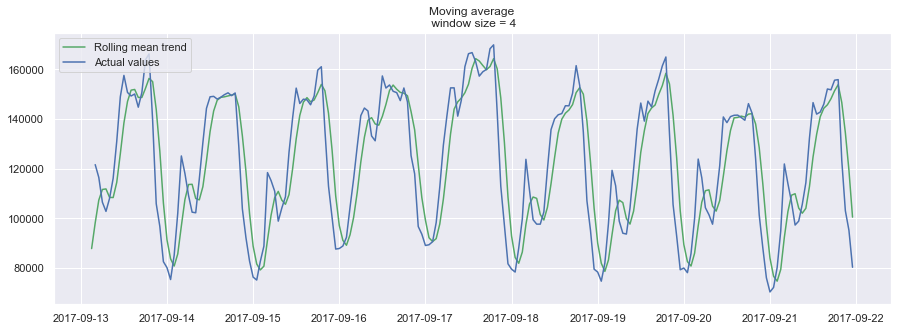

In [23]:
plotMovingAverage(ads, 4) # 移动窗口为4小时

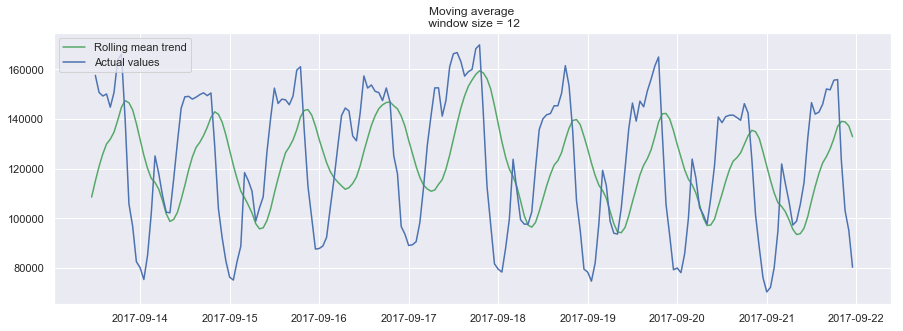

In [24]:
plotMovingAverage(ads, 12) # 移动窗口为12小时

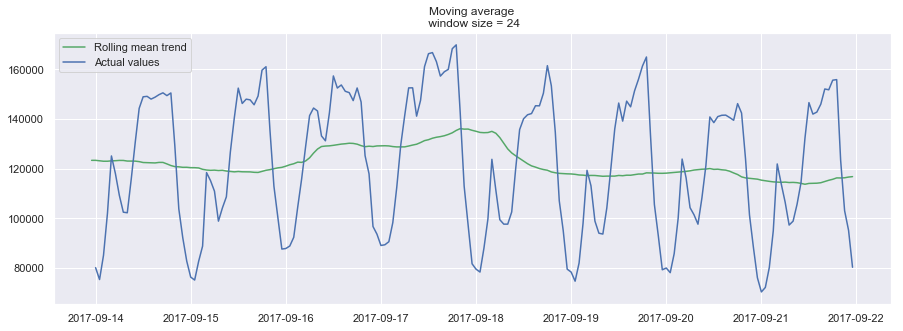

In [25]:
plotMovingAverage(ads, 24) # 移动窗口为 24 小时

以24小时作为滑动窗口的大小，来分析玩家每小时浏览广告量的信息时，可以看到广告浏览量的变化趋势，周末时的浏览量较高

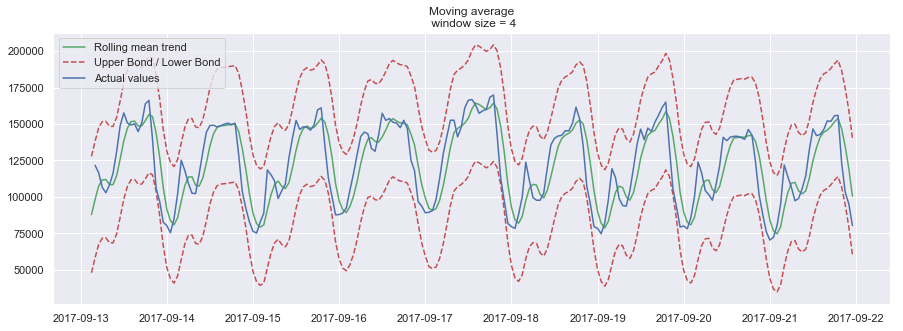

In [33]:
plotMovingAverage(ads, 4, plot_intervals=True)

现在用moving average 来创建一个简单的异常检测系统（即如果数据点落在置信区间外，则认为是异常点）。显然我们上面的数据只能够，数据点都在置信区间内，因此我们故意把数据中的某个值改为异常值。

In [34]:
ads_abnormal = ads.copy()
ads_abnormal.iloc[-20] = ads_abnormal.iloc[-20]*0.2 # say we have 80% drop of ads

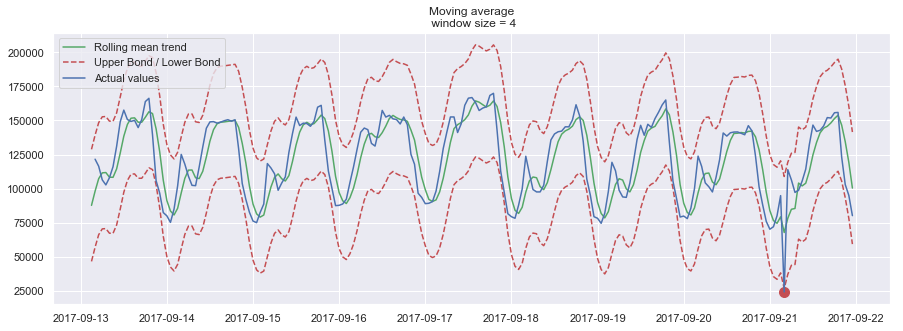

In [37]:
plotMovingAverage(ads_abnormal, 4, plot_intervals=True, plot_abnormalies=True)

找到了异常点的位置（2017-09-21）

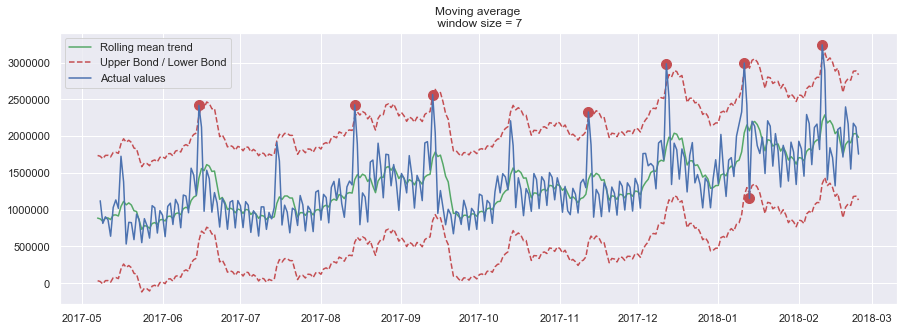

In [38]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_abnormalies=True)

这就暴露了简单方法的缺点，它没有在数据中捕捉到每个月中出现的季节性变化，反倒是几乎把每隔30天出现的峰值标记为异常。

### 考虑更复杂的模型

### 1. weighted average

时间距离越近的观测点，权重越大

In [47]:
def weighted_average(series, weights):
    '''
    calculate weighted average on series
    '''
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [48]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

### 2. 一次 exponential smoothing # 指数平滑

St=aYt-1+(1-a)St-1

In [78]:
def exponential_smoothing(series, alpha):
    '''
    series: dataset with timestamps
    alpha: float[0.0, 1.0], smoothing parameter
    '''
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha*series[n] + (1 - alpha) * result[n-1])
    return result

In [79]:
def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            result = exponential_smoothing(series, alpha)
            plt.plot(result, label='Alpha {}'.format(alpha))
        plt.plot(series.values, 'c', label='Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Exponential Smoothing')
        plt.grid(True)

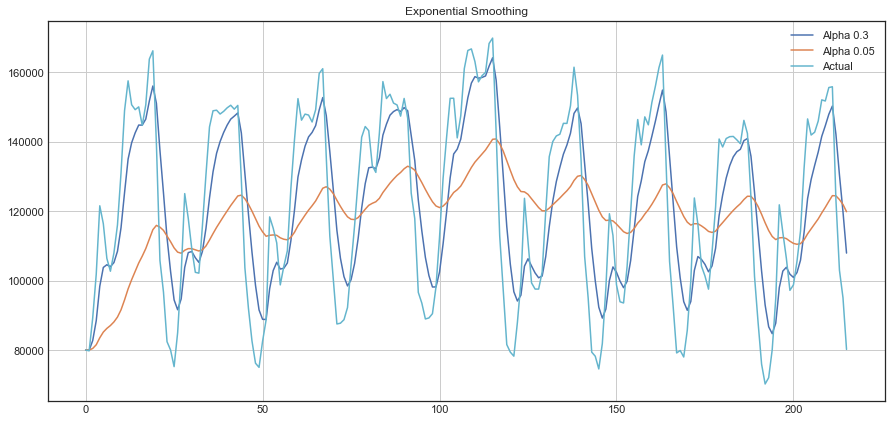

In [80]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

α 越小，表示当前真实观测值的影响力越小，而前一个模型预测值的影响力越大，最终得到的时间序列会更平滑。

那么指数提现在哪里呢？指数就隐藏在递归函数之中，上面的函数，每次都要用 (1-α)乘以模型的上一个预测值

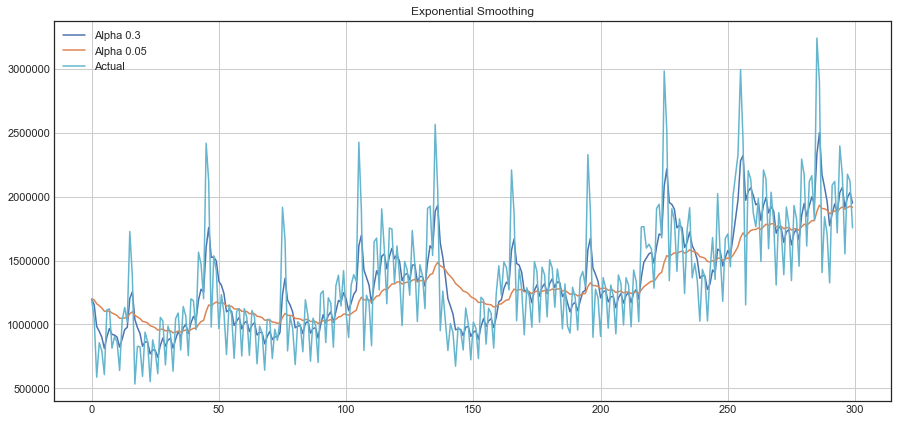

In [81]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

单指数平滑小结

1. 特点：能够追踪数据变化，预测过程中，添加了最新的样本数据之后，新数据逐步取代老数据的地位，最终老数据也会被淘汰

2. 局限：1）预测值不能够反映趋势的变动、季节波动等有规律的变动；2）适用于短期预测，而不适用中长期预测；3）由于预测值是历史数据的均值，因此与实际序列相比，有滞后现象

3. 系数：Eviews 提供两种确定指数平滑系数的方法：自动给定和人工确定。一般来说，如果序列变化比较平缓，平滑系数应该比较小，如0.1；若序列变化比较剧烈，平滑系数可以大一些，如0.3-0.5；若平滑系数值大于0.5才能跟上序列的变化，表明序列有很强的趋势，不能采用一次指数平滑进行预测。

### 3. double exponential smoothing

单指数平哈在产生新的序列时，考虑了前面的K条历史数据，但是仅仅考虑了其静态值，没有考虑时间序列当前的变化趋势。

而，如果当前时间序列数据处于上升趋势，那么我们对于明天的数据的预测，就不应该仅仅是对历史数据进行‘平均’，还应考虑到当前数据变化的上升趋势。

同时考虑历史平均和变化趋势，就是双指数平滑法。

通过 序列分解法 (series decomposition)，我们可以得到两个分量，一个叫 intercept (also, level) ℓ，另一个叫 trend (also, slope，斜率). 我们根据前面学习的方法，知道了如何预测 intercept （截距，即序列数据的期望值），我们可以将同样的指数平滑法应用到 trend (趋势)上。时间序列未来变化的方向取决于先前加权的变化。

Yt+1 = Lt + Bt

In [86]:
def double_exponential_smoothing(series, alpha, beta):
    '''
    series: data set with timeseries
    alpha: float [0.0, 1.0], smoothing parameter for level
    beta: float [0.0, 1.0], smoothing parameter for trend
    '''
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [87]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                result = double_exponential_smoothing(series, alpha, beta)
                plt.plot(result, label='Alpha {}, beta {}'.format(alpha, beta))
        plt.plot(series.values, label='Actual')
        plt.axis('tight')
        plt.title('Double Exponential Smoothing')
        plt.legend(loc='best')
        plt.grid(True)

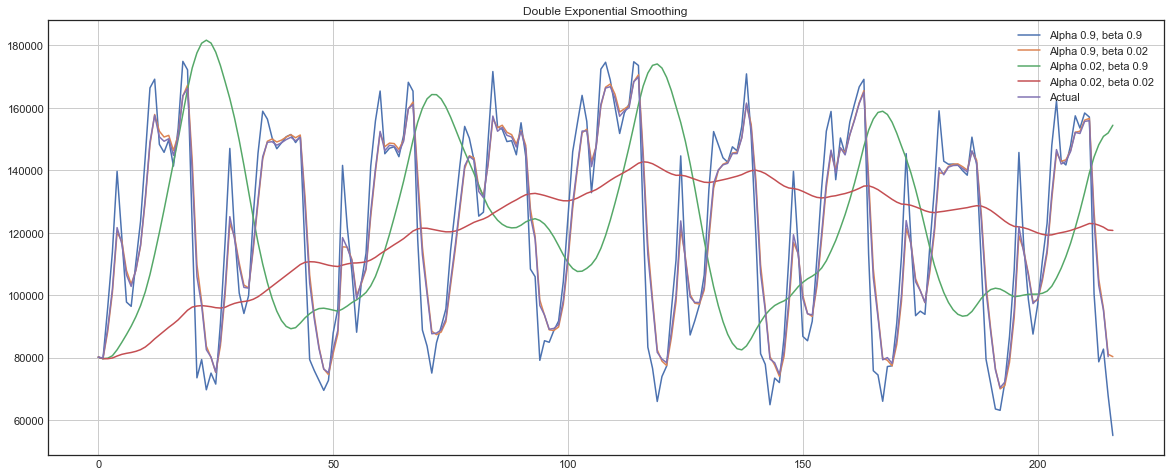

In [89]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

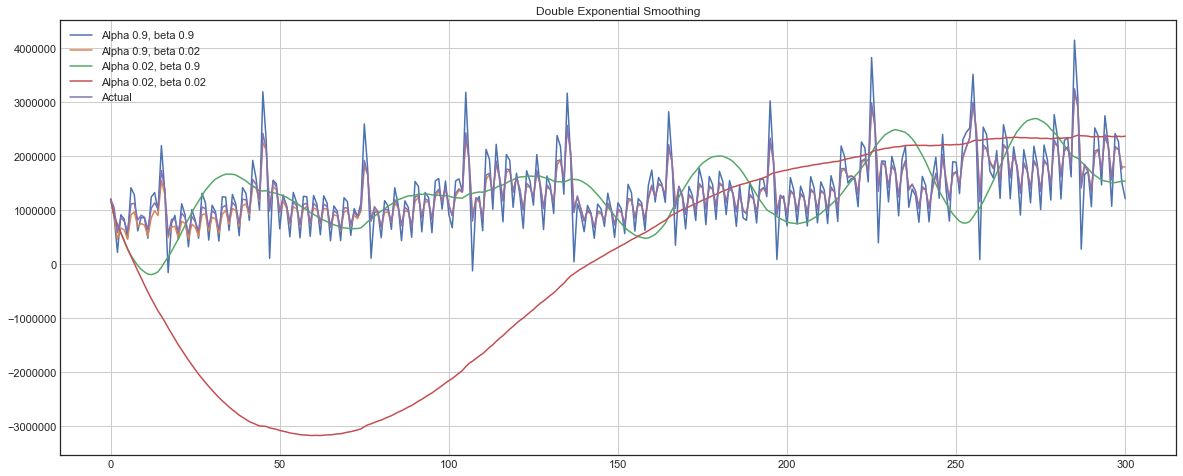

In [90]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

双指数平滑需要调整两个参数 α 和 β，前者决定时间序列数据自身变化趋势的平滑程度，后者决定趋势的平滑程度。

### 4. Triple exponential smoothing

三指数平滑，也称为 Holt-Winters 平滑，与前两种平滑方法相比，多考虑了一个 seasonality （季节性）因素。也就意味着，如果我们的时间序列数据不存在季节性变化，就不适用三指数平滑了。

#### 模型中的 季节性 分量，用来解释 截距 和 趋势 的重复变化，并且由 季节长度 来描述，也就是变化重复的周期来描述。

下面是 Holt-Winters 模型代码，模型中还引入了 Brutlag 方法，以创建置信区间。

In [163]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
            print(len(self.series))
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])


## 时间序列交叉验证

接下来动手找出 Holt-Winters 模型在玩家每小时的广告浏览量数据集中的最佳参数，根据常识可知，在这个数据集中，存在一个明显的季节性变化趋势，变化周期为24小时，因此我们设 slen = 24


In [164]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))


### 在 Holt-Winters 模型以及其他指数平滑模型中，平滑指数在0和1之间，这里使用 truncated Newton conjugate gradient （截断牛顿共轭梯度法）

In [165]:
from scipy.optimize import minimize


data = ads.Ads[:-20] # leave some data for test

# initializing model parameters
x = [0, 0, 0]

# minimizing loss function
opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_squared_error), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))

# take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# obtain the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen=24, alpha=alpha_final,
                   beta=beta_final, gamma=gamma_final, n_preds=50, scaling_factor=3)
model.triple_exponential_smoothing()

slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
s

slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
14

49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
9

slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
s

slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
s

98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
9

slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
14

slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
s

98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
9

slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
s

slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
s

49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
4

slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
s

slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
s

slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
s

slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
s

slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
s

slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
s

slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
14

slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
s

slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
14

slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
14

slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
14

slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
14

slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
s

147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  4

slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
14

slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
s

slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
s

147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  4

slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
s

slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
s

49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
4

slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
14

slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
s

slen:  24
147
slen:  25
147
slen:  26
147
slen:  27
147
slen:  28
147
slen:  29
147
slen:  30
147
slen:  31
147
slen:  32
147
slen:  33
147
slen:  34
147
slen:  35
147
slen:  36
147
slen:  37
147
slen:  38
147
slen:  39
147
slen:  40
147
slen:  41
147
slen:  42
147
slen:  43
147
slen:  44
147
slen:  45
147
slen:  46
147
slen:  47
147
slen:  24
49
slen:  25
49
slen:  26
49
slen:  27
49
slen:  28
49
slen:  29
49
slen:  30
49
slen:  31
49
slen:  32
49
slen:  33
49
slen:  34
49
slen:  35
49
slen:  36
49
slen:  37
49
slen:  38
49
slen:  39
49
slen:  40
49
slen:  41
49
slen:  42
49
slen:  43
49
slen:  44
49
slen:  45
49
slen:  46
49
slen:  47
49
slen:  24
98
slen:  25
98
slen:  26
98
slen:  27
98
slen:  28
98
slen:  29
98
slen:  30
98
slen:  31
98
slen:  32
98
slen:  33
98
slen:  34
98
slen:  35
98
slen:  36
98
slen:  37
98
slen:  38
98
slen:  39
98
slen:  40
98
slen:  41
98
slen:  42
98
slen:  43
98
slen:  44
98
slen:  45
98
slen:  46
98
slen:  47
98
slen:  24
147
slen:  25
147
slen:  26
14

In [150]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label='Model')
    plt.plot(series.values, label='Actual')
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
        series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
        series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, 'o', markersize=10, label='Anomalies')
        
    if plot_intervals:
        plt.plot(model.UpperBond, 'r--', alpha=0.5, label='Up/Low confidence')
        plt.plot(model.LowerBond, 'r--', alpha=0.5)
        plt.fill_between(x=range(0, len(model.result)), y1=model.UpperBond, y2=model.LowerBond,
                        alpha=0.2, color='grey')
        plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond),
                  linestyles='dashed')
        plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
        plt.grid(True)
        plt.axis('tight')
        plt.legend(loc='best', fontsize=13)

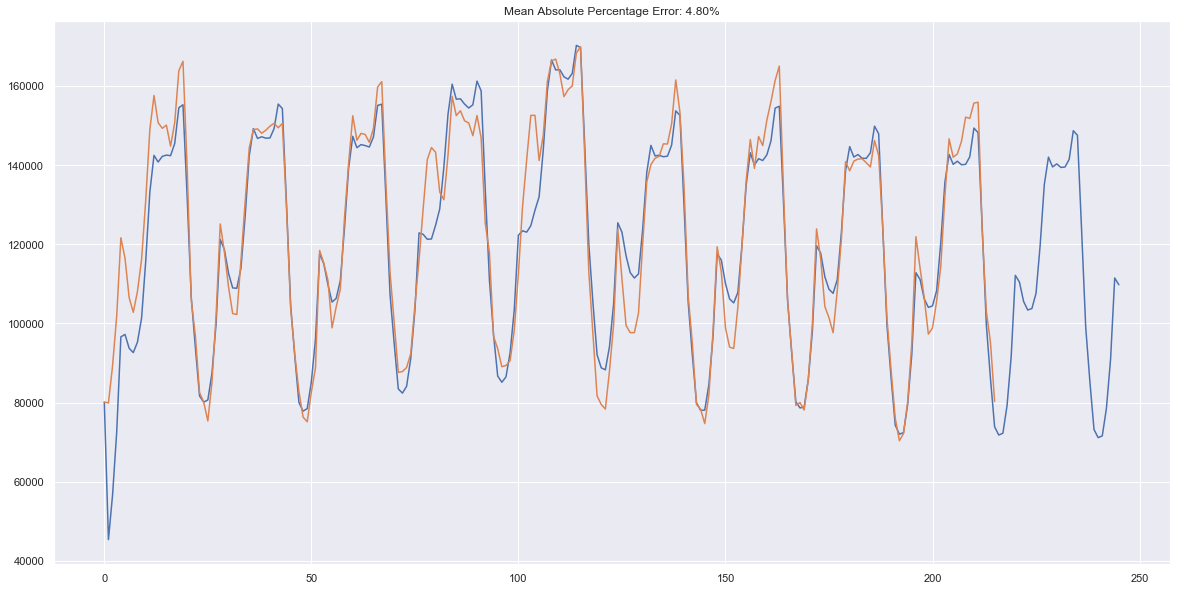

In [151]:
plotHoltWinters(ads.Ads)

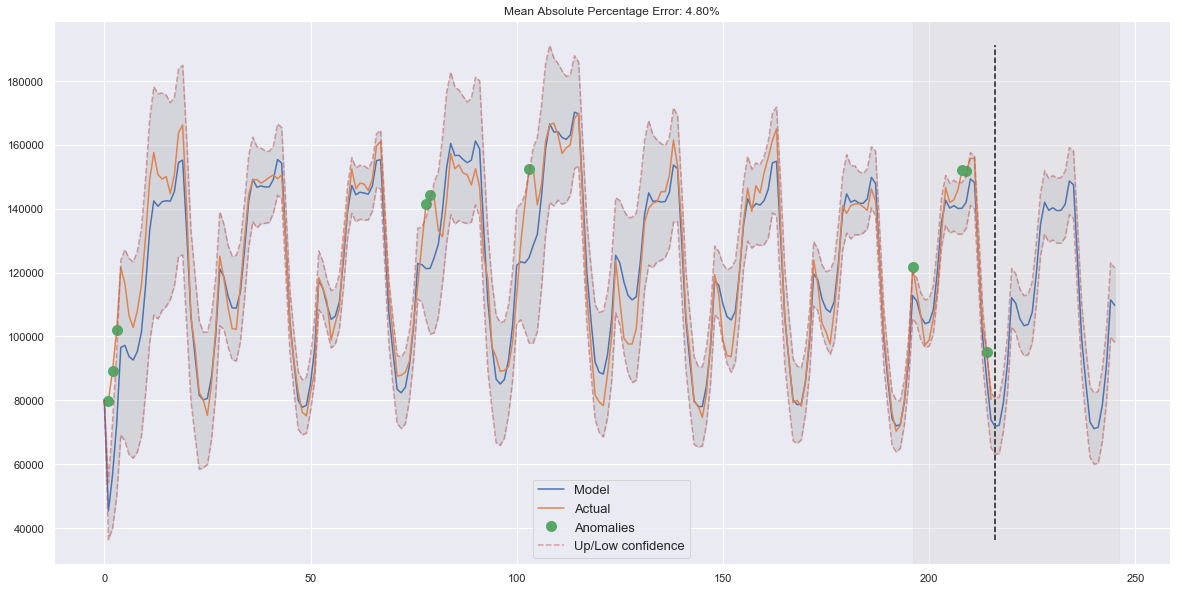

In [152]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

从图上可以判断我们的模型以及成功逼近初始时间序列，捕捉到日季节性，整体下降趋势，甚至一些异常。但如果看一下模型的偏差 （deviation），可以清楚的看到模型对序列结构的变化反应非常强烈，但是很快就会把偏差恢复到正常值，‘遗忘’过去。
模型的这一特性允许我们快速构建异常检测系统，即使对于非常嘈杂的系列，也不需要花费太多时间和金钱来准备和训练模型

Text(0.5, 1.0, "Brutlag's predicted deviation")

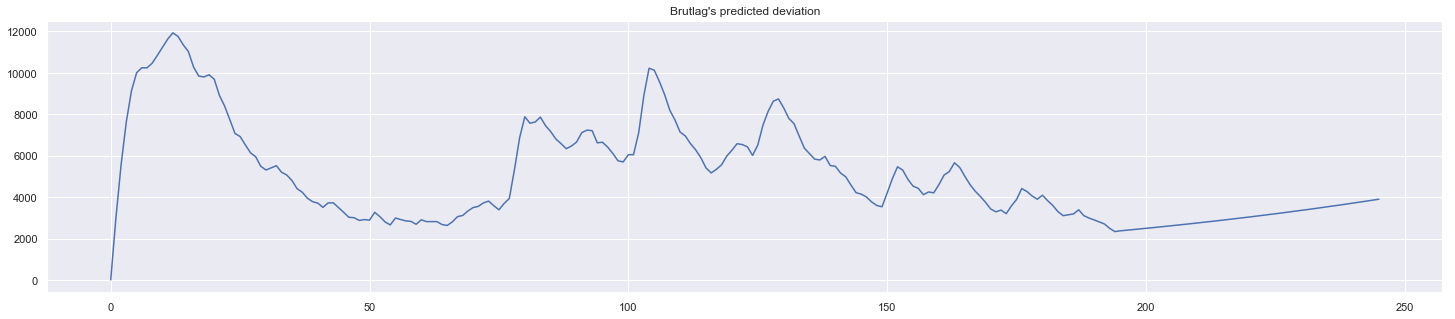

In [153]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")

把同样的方法应用于第二个时间序列（玩家每天游戏币的消费情况），这里把季节性周期设置为30

In [158]:
data = currency.GEMS_GEMS_SPENT[:-50]
slen = 30

x = [0, 0, 0]

opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_absolute_percentage_error, slen),
              method='TNC', bounds=((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)

model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777


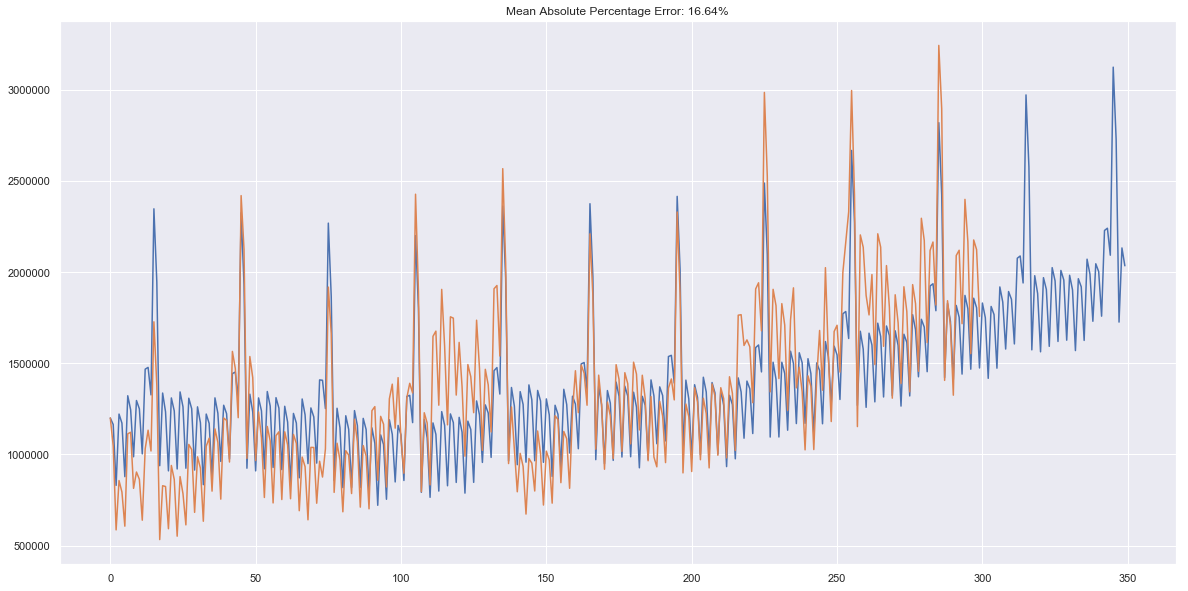

In [159]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

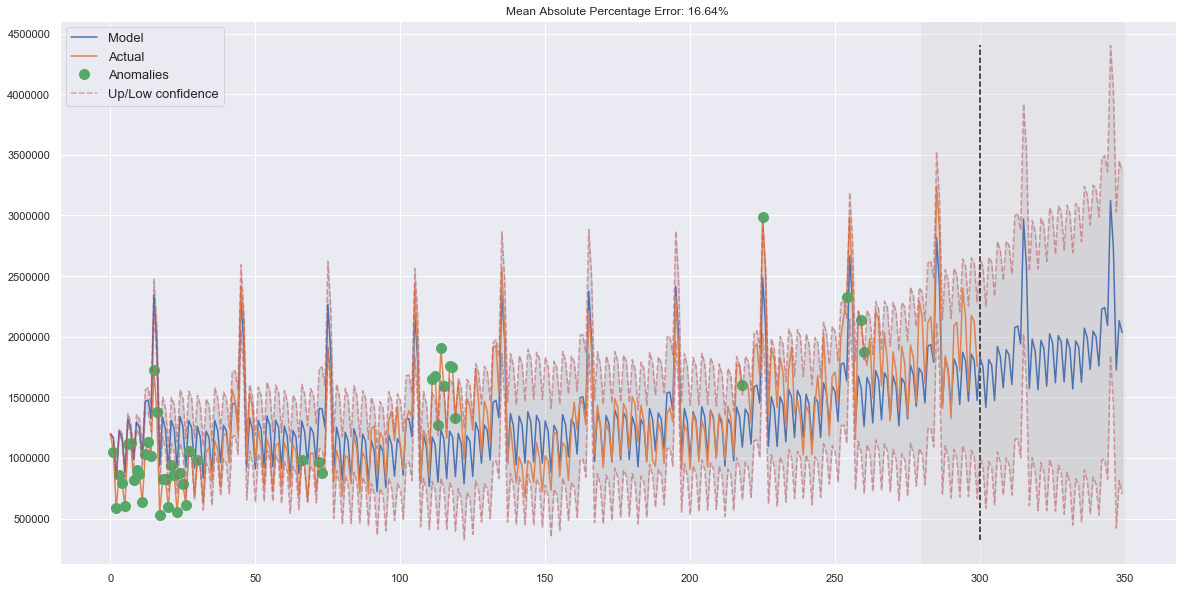

In [161]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

Text(0.5, 1.0, "Brutlag's predicted deviation")

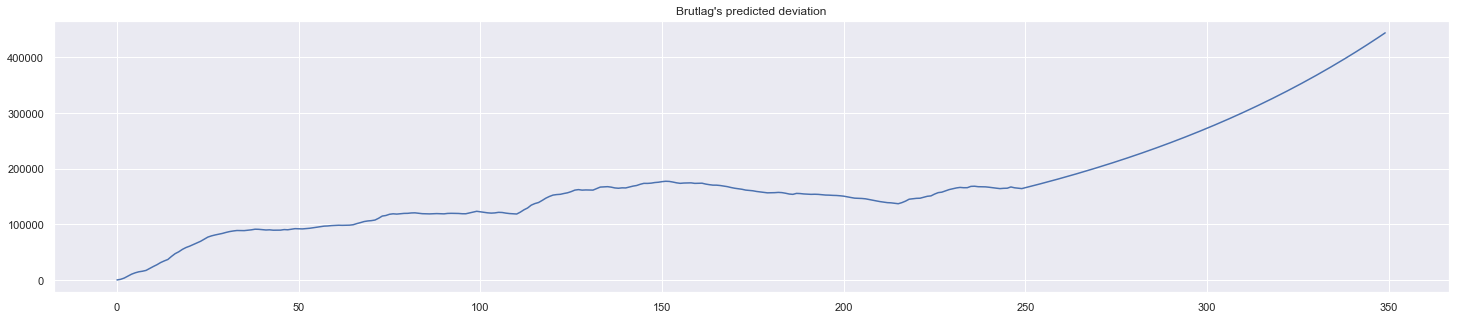

In [162]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")

## 计量经济学方法

平稳性：我们称一个时间序列是平稳的，是指它不会随着时间的改变而改变其统计特性，即平均值和方差不会随时间而改变。

为什么平稳性这么重要？ 因为大多数时间序列的模型，或多或少都是基于未来序列与目前已观测到的序列数据有着相同的统计特性（均值、方差等）的假设。也就是说，如果原始序列（已观测序列）是不平稳的，那么我们现有的模型的预测结果就可以会出错。

现实数据大都是不平稳的，那进行预测之前，就把它变成平稳的！

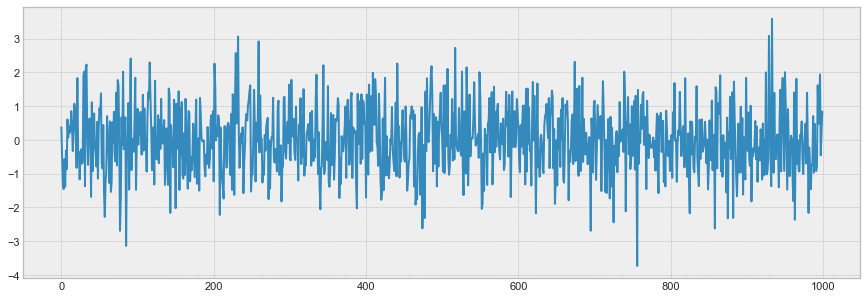

In [166]:
# 绘制白噪声

white_noise = np.random.normal(size=1000) # 通过正态分布生成的样本，它的分布显然平稳，均值为0，方差为1
with plt.style.context('bmh'):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

现在来看随机游走

X(t) = ρ*X(t-1) + e(t)

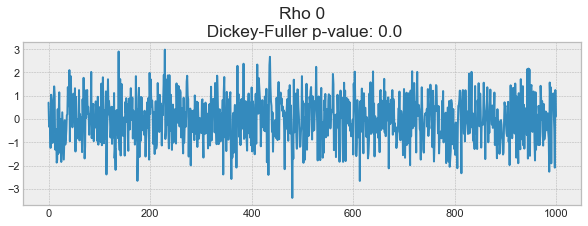

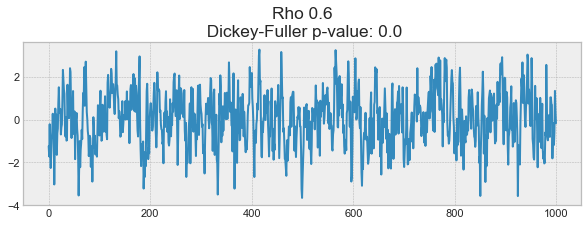

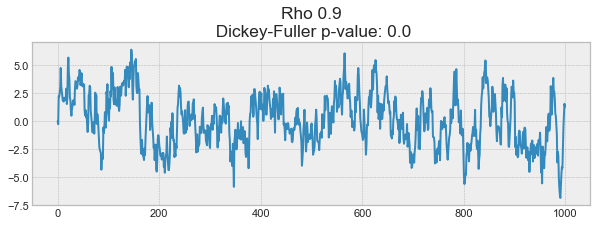

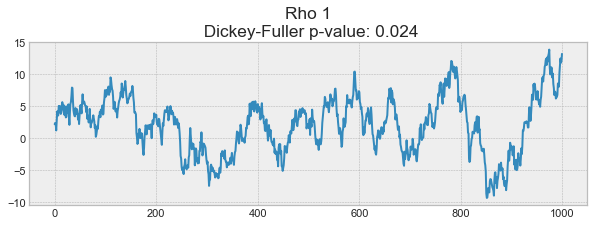

In [168]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]
        
    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title('Rho {}\n Dickey-Fuller p-value: {}'.format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

ρ = 1.0时，新的样本分布出现随机游走，变为不稳定分布。


X(t) - X(t-1) = (ρ-1)* X(t-1) + e(t)
等式左边称为一阶差分，如果 ρ=1, 则一阶差分则为平稳的白噪声 e(t)，这个正是 Dickey-Fuller 时间序列平稳性检验（单位根的存在）的思想。

一阶差分并不总是足以得到平稳序列，因为可能是 d 阶单整且 d>1（具有多个单位根），在这种情况下，需要使用增广迪基-福勒检验 （augmented Dickey-Fuller test）

### SARIMA 模型构建
现在来构建一个 SARIMA 模型

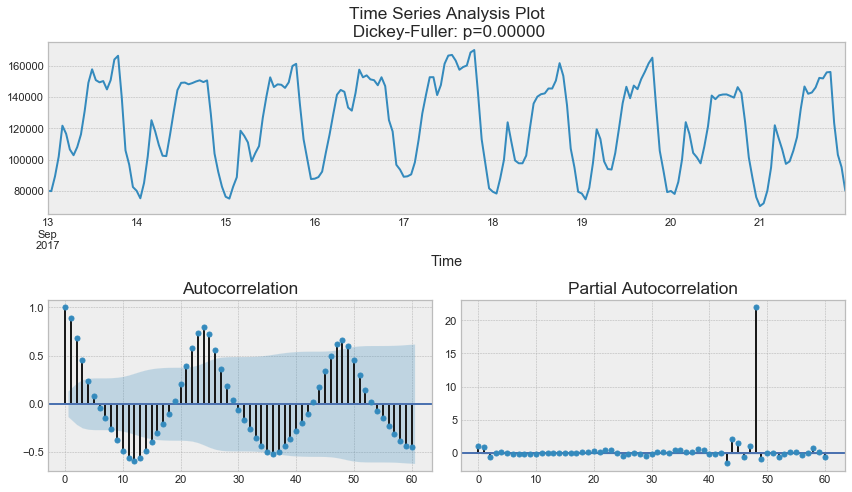

In [175]:
# 先绘制时间序列图、ACF 和 PACF 图

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    '''
    plot time series, its ACF, PACF, calculate Dickey-Fuller test
    y - timeseries
    lags - how many lags to include in ACF, PACF calculation
    '''
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plot\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(ads.Ads, lags=60)

#### 出乎意料的是，初始序列是平稳的，Dickey-Fuller test拒绝了存在单位根的零假设。实际上，从上面的图像就可以看出没有明显的趋势，所以均值是恒定的, 整个序列的方差也相对比较稳定。在建模之前，我们只需要处理季节性，为此让我们才有‘季节差分’，也就是对序列进行简单的减法操作，时差等于季节周期。

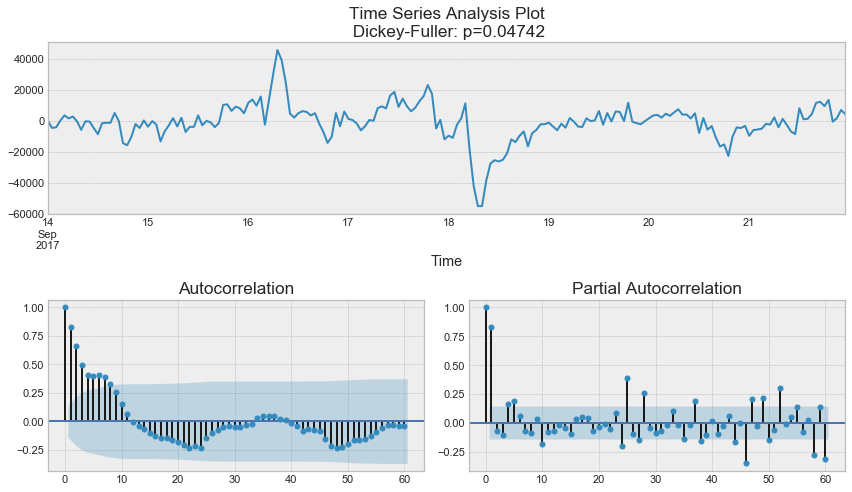

In [178]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

#### 观察上图，图表中可见的季节性消失，但是自相关性（autocorrelation）函数仍然有太多明显滞后的情况（图中浅色阴影之外的一些点为滞后点），为了移除它们，取一阶差分：从序列中减去自身

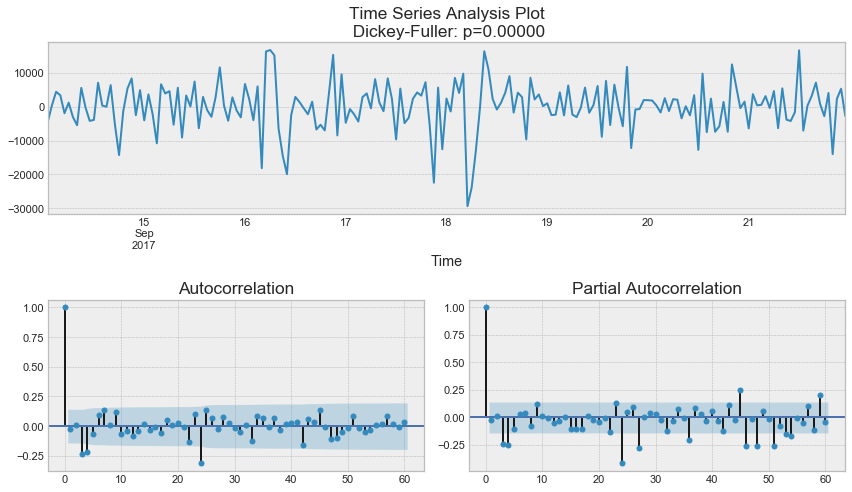

In [179]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

#### 可以看到，序列是在零周围震荡，Dickey-Fuller test 表明它是平稳的，ACF中明显的尖峰不见了，可以开始建模了！

SARIMA(p, d, q)(P, D, Q, s)

其中：

AR(p) - 自回归模型，基本假设是当前的序列值取决于它之前的值，并且存在一定的滞后性。模型的最大滞后值称为p，要确定p的值，需要在PCAF图中找到最大的滞后点

MA(q) - 移动平均值模型，当前的误差依赖于先前的误差，有一定的滞后性，记为 q，在ACF 图中找到滞后值 q的初始值

AR(p) + MA(q) = ARMA(p, q) - 自回归移动平均模型，两个基本模型都是平稳的，如果初始序列是平稳的，可以通过这个模型逼近这一序列

I(d) - d 阶，表示使得序列变得平稳所需的非季节性差分的阶数

加上差分得到 ARIMA(p, d, q) 模型，可以通过非季节性差分处理非平稳数据

S(s) - 字母 S 表示序列是季节性的， S(s) 等于这个姐姐周期的长度值

P：自回归模型的季节性分量的阶数，通氧可以从PACF图中得到，但是这次需要看显著滞后的数量，P 是季节周期长度的倍数，例如，周期=24，并且看PACF图，看到第24和第48滞后是显著的，那么出事P就是2

Q：移动平均模型中季节分量的阶数，初始值的确定和 P 同理，但是使用 ACF 图

D：季节性差分，取值等于1或者0，表示是否应用季节差分

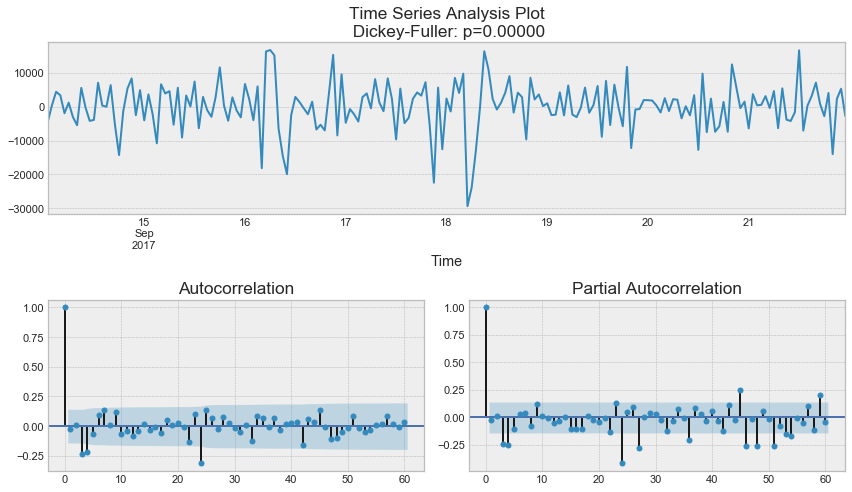

In [181]:
tsplot(ads_diff[24+1:], lags=60)

1. 可以观察到 p最有可能是4，从PACF图中，可以观测到的最大滞后值
2. d 等于1，因为我们使用的是一阶差分
3. q 大概等于 4， 从 ACF 可以看出
4. P 应该等于2，因为 PACF 图中第24和48个是比较明显的滞后点
5. D 等于1，表示我们需要进行 季节性差分处理
6. Q 可能是 1， 因为从 ACF 图中看，第24个滞后点是比较明显的，而第48个滞后点不太明显

那么现在对 SARIMA 模型进行参数搜索，看看那组参数效果最好

In [190]:
# 设置参数搜索区间

# setting initial values and some bounds for parameters

ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 3)
D = 1
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [193]:
# 寻找 SARIMA 模型的最佳参数组合

def optimizeSARIMA(parameters_list, d, D, s):
    '''
    return dataframe with parameters and corresponding AIC
    '''
    
    results = []
    best_aic = float("inf")
    
    for param in tqdm_notebook(parameters_list):
        # we need to try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        
        aic = model.aic
        
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    print(results)
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [194]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [195]:
print(result_table)

      parameters          aic
0   (2, 3, 1, 1)  3888.642174
1   (3, 2, 1, 1)  3888.763568
2   (3, 2, 2, 1)  3889.705536
3   (2, 3, 2, 1)  3889.717128
4   (4, 2, 1, 1)  3890.279740
5   (3, 3, 1, 1)  3890.513196
6   (4, 2, 2, 1)  3891.321956
7   (3, 3, 2, 1)  3891.504900
8   (2, 4, 1, 1)  3892.302849
9   (4, 3, 1, 1)  3892.322832
10  (4, 3, 2, 1)  3893.270868
11  (2, 4, 2, 1)  3893.354723
12  (3, 4, 1, 1)  3893.762846
13  (4, 4, 1, 1)  3894.327681
14  (3, 4, 2, 1)  3894.541376
15  (2, 2, 1, 1)  3894.798147
16  (2, 2, 2, 1)  3895.540273
17  (4, 4, 2, 1)  3895.687581
18  (2, 3, 0, 1)  3897.170902
19  (3, 2, 0, 1)  3897.815032
20  (4, 2, 0, 1)  3899.073591
21  (3, 3, 0, 1)  3899.165271
22  (3, 4, 0, 1)  3900.499848
23  (2, 4, 0, 1)  3900.502494
24  (4, 3, 0, 1)  3901.255700
25  (3, 2, 2, 0)  3902.166858
26  (2, 3, 2, 0)  3902.216914
27  (4, 4, 0, 1)  3902.756683
28  (4, 2, 2, 0)  3903.865866
29  (2, 2, 0, 1)  3903.905714
30  (3, 3, 2, 0)  3904.005424
31  (2, 4, 2, 0)  3904.992910
32  (4, 3,

In [199]:
p, q, P, Q = result_table.parameters[0]
best_model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Fri, 05 Mar 2021   AIC                           3888.642
Time:                                      00:36:18   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

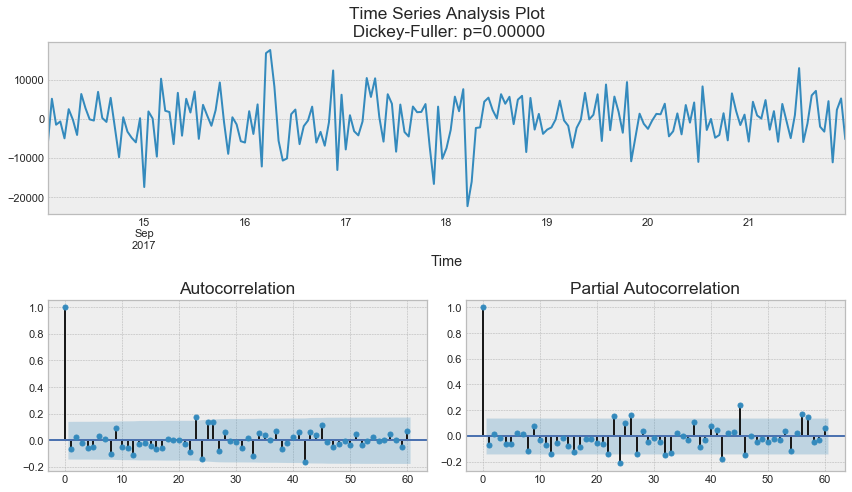

In [200]:
# 来绘制模型的残差分布情况

tsplot(best_model.resid[24+1:], lags=60)

很明显，模型的残差是平稳的，没有明显的自相关，让我们用此模型进行预测

In [207]:
def plotSARIMA(series, model, n_steps):
    '''
    plot model vs predicted values
    '''
    
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    
    # making a shift on s+d steps, because these values were unobsered by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title('Mean Absolute Percentage Error: {0:.02f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label='actual')
    plt.legend()
    plt.grid(True)

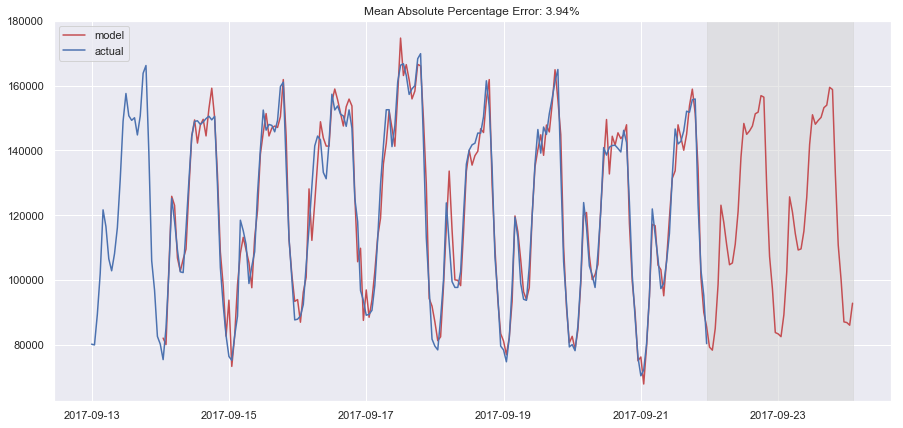

In [208]:
plotSARIMA(ads, best_model, 50)

## 时间序列的（非）线性模型

在工作中，构建模型的原则是快、好、省。 这也就意味着有些模型并不适合用于生产环境。

因为它们需要过长的数据准备时间，或者需要频繁地重新训练新数据，或者很难调整参数（前面提到的 SARIMA 模型就包含了着三个缺点）。

因此，我们一般使用一些轻松得多的方法，比如说从现有时间序列中选取一些特征，然后创建一个简单的线性回归或随机森林模型。

现在我们有的只是一个一维时间序列，可以提取的特征：
1. 时间序列的滞后值
2. 窗口相关统计量：1）一个窗口序列中的最大最小值 2）一个窗口序列中的平均值和中位数 3）窗口的方差
3. 日期和时间特征：1）每小时的第几分钟，每天的第几个销售，每周的第几天 2）是否节假日，是否有特别的事情发生了，可以作为布尔值特征
4. 目标值编码
5. 其他模型的预测值

时间序列的滞后值

如果移动1时差，并训练模型预测为例，那么模型将能够提前预测1步

In [244]:
data = pd.DataFrame(ads.Ads.copy())
data.columns = ['y']

# adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data['lag_{}'.format(i)] = data.y.shift(i)

In [234]:
# use linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[: test_index]
    y_train = y.iloc[: test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, 'g', label='prediction', linewidth=2.0)
    plt.plot(y_test.values, label='actual', linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
        deviation = np.sqrt(cv.std())
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, 'r--', label='upper/lower bounds', alpha=0.5)
        plt.plot(upper, 'r--', alpha=0.5)
        
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(y_test))
        anomalies[y_test<lower] = y_test[y_test<lower]
        anomalies[y_test>upper] = y_test[y_test>upper]
        plt.plot(anomalies, 'o', markersize=10, label='Anomalies')
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title('Mean Absolute Percentage Error {0:.2f}%'.format(error))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)

In [257]:
def plotCoefficients(model):
    '''
    plot sorted coefficient values of the model
    '''
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ['coef']
    coefs['abs'] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by='abs', ascending=False).drop(['abs'], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

In [258]:
y = data.dropna().y
X = data.dropna().drop('y', axis=1)

In [259]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape)

(134, 19) (58, 19)


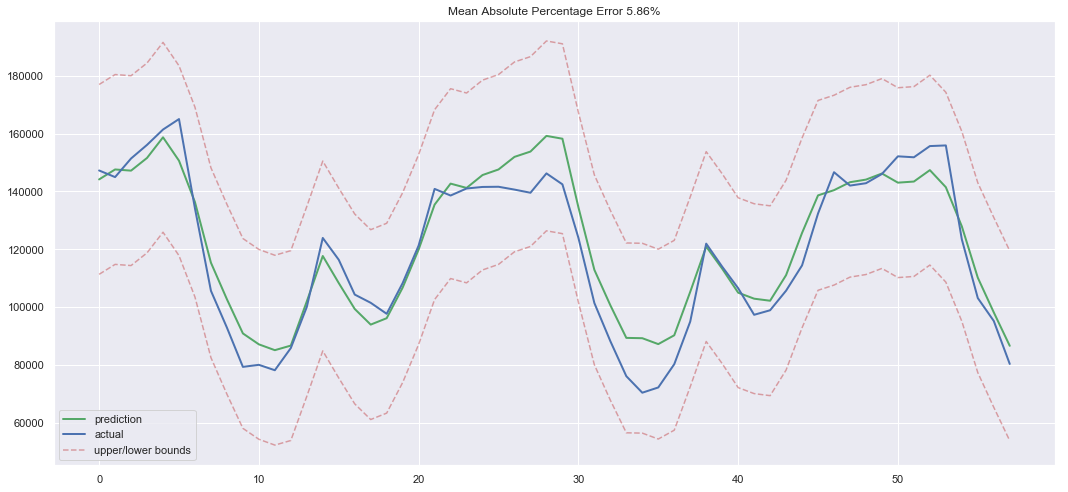

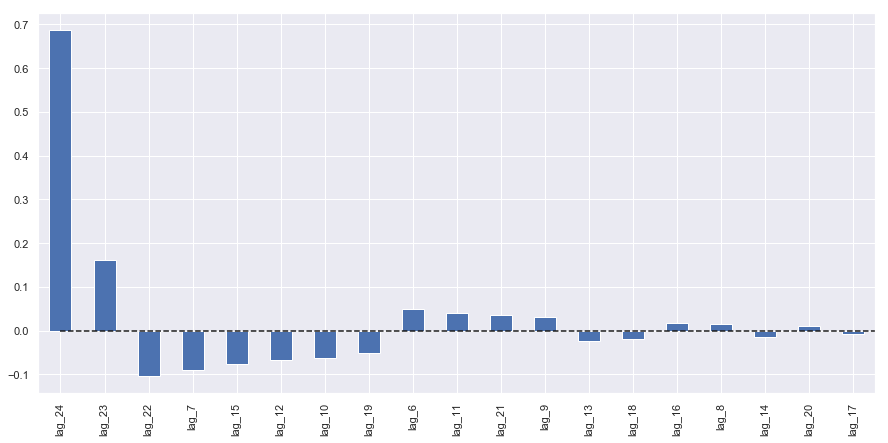

In [260]:
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, X_train=X_train, X_test=X_test, plot_intervals=True)
plotCoefficients(lr)

简单的处理，效果还行，但是有大量不必要的特征

In [263]:
data.head(3)

y  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  \
Time                                                                     
2017-09-13 00:00:00  80115    NaN    NaN    NaN    NaN     NaN     NaN   
2017-09-13 01:00:00  79885    NaN    NaN    NaN    NaN     NaN     NaN   
2017-09-13 02:00:00  89325    NaN    NaN    NaN    NaN     NaN     NaN   

                     lag_12  lag_13  lag_14  lag_15  lag_16  lag_17  lag_18  \
Time                                                                          
2017-09-13 00:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2017-09-13 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2017-09-13 02:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                     lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  
Time                                                                 
2017-09-13 00:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
2017-09-13 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN  
2017-09-13 02:00:00     NaN     NaN     NaN     NaN     NaN     NaN

In [266]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

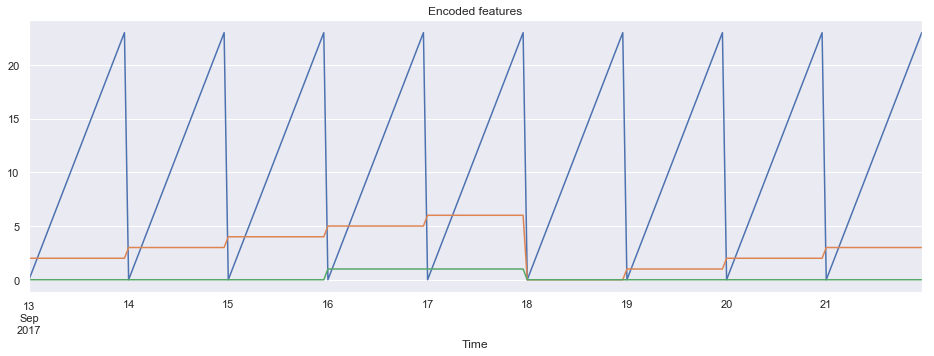

In [268]:
plt.figure(figsize=(16, 5))
plt.title('Encoded features')
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True)

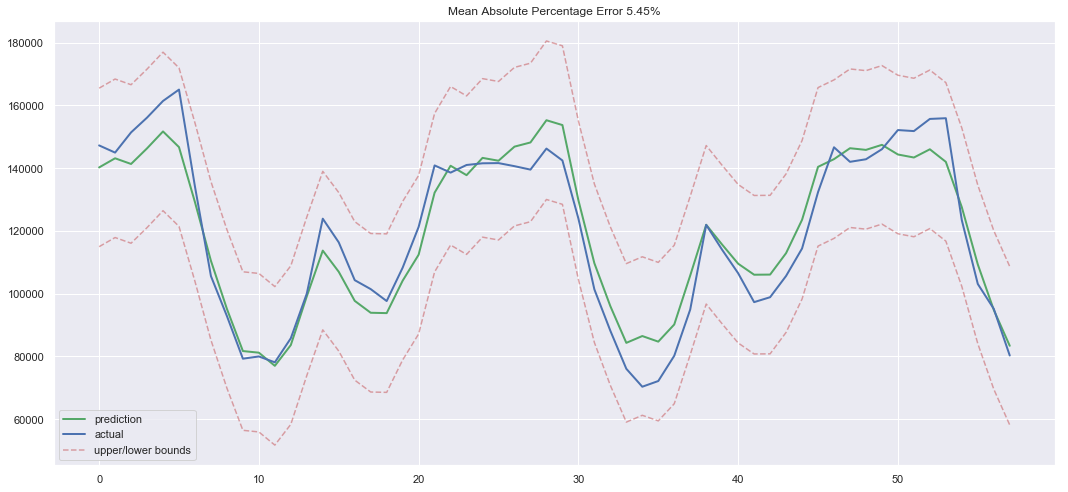

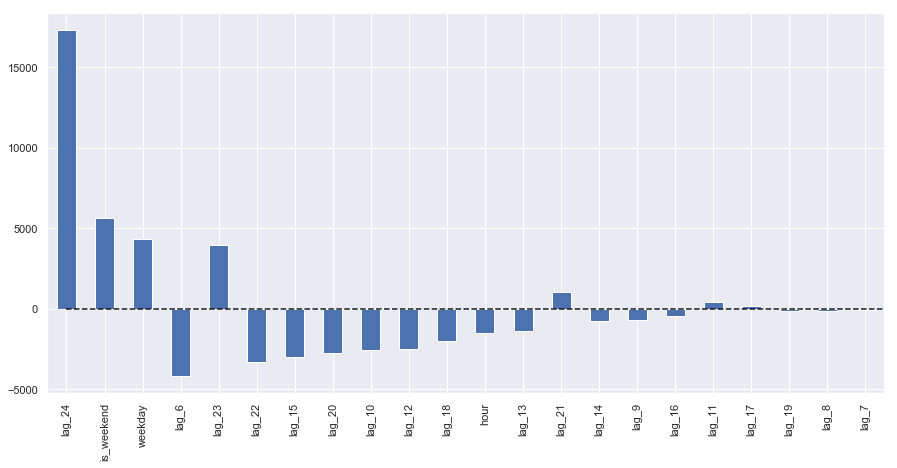

In [270]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)


In [271]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

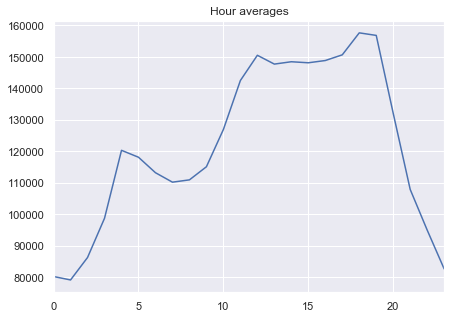

In [272]:
average_hour = code_mean(data, 'hour', 'y')
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True)

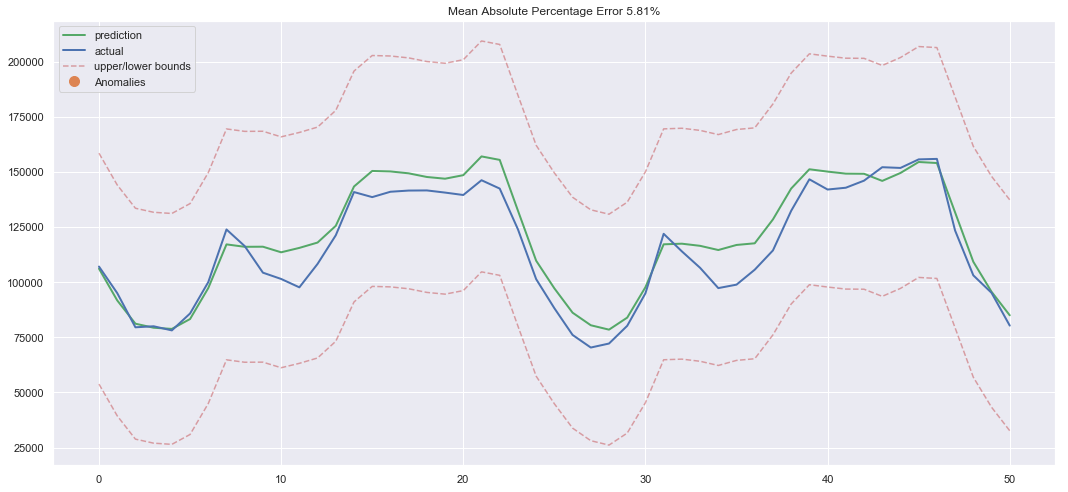

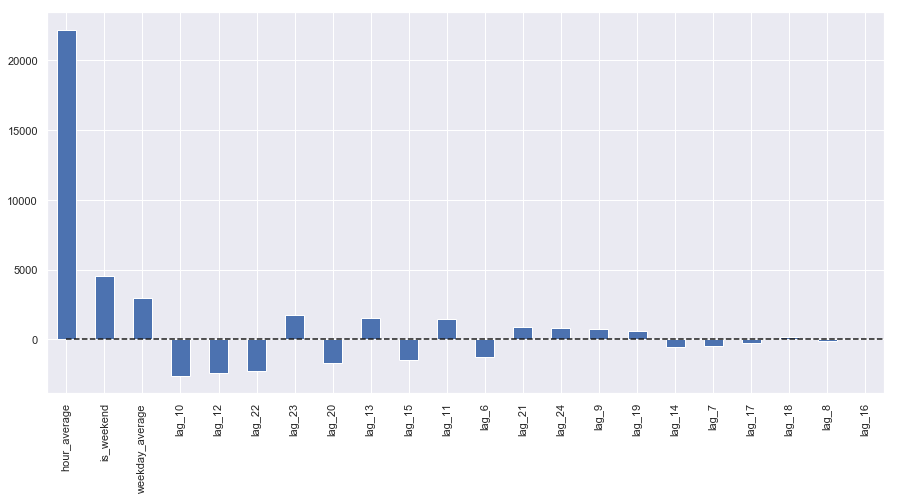

In [274]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries
        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today
        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today
        test_size: float
            size of the test dataset after train/test split as percentage of dataset
        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(
            code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(
            code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test =\
    timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test
  
  
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)


In [276]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


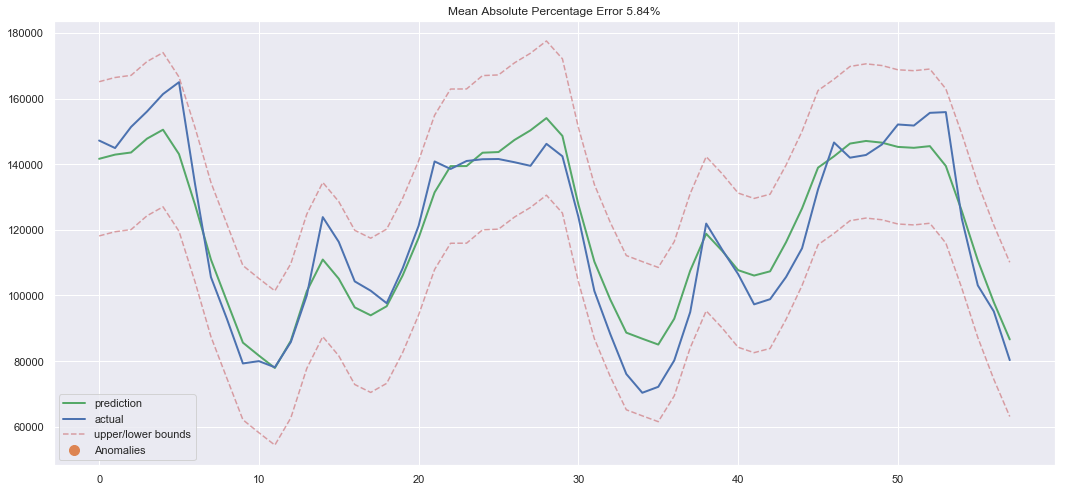

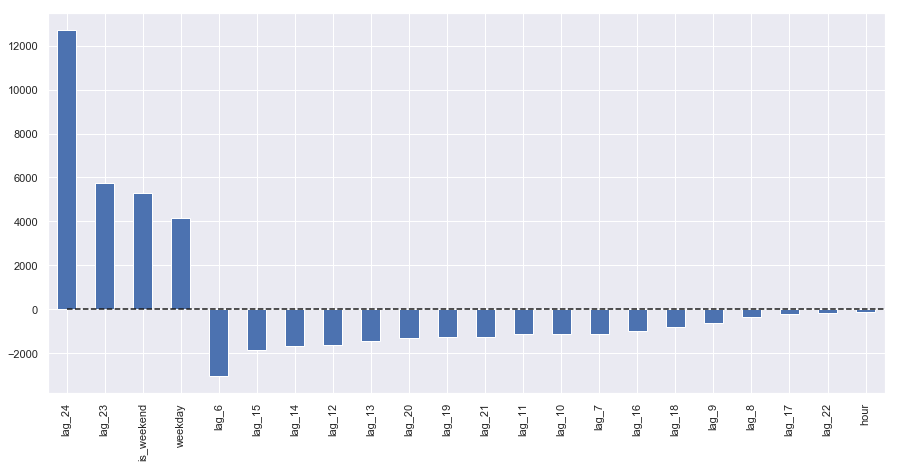

In [277]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)


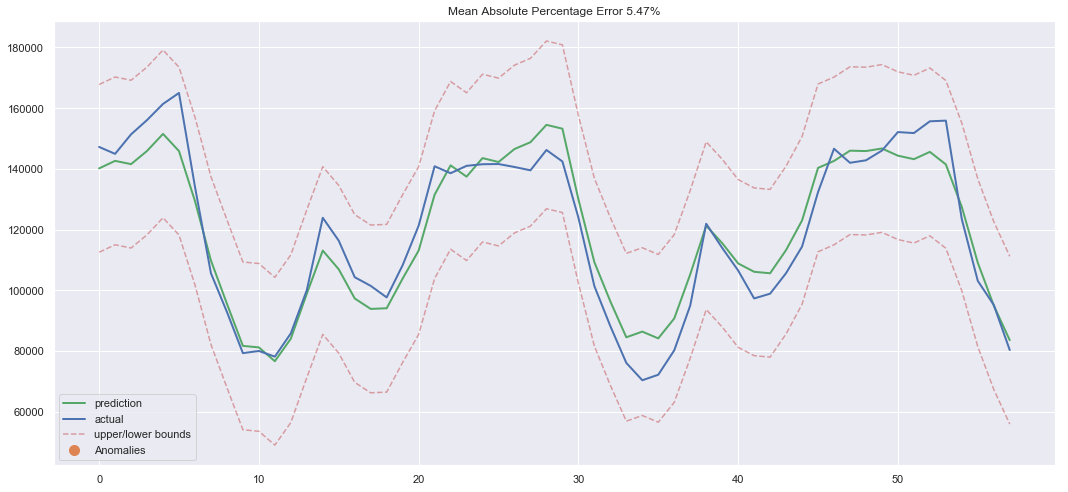

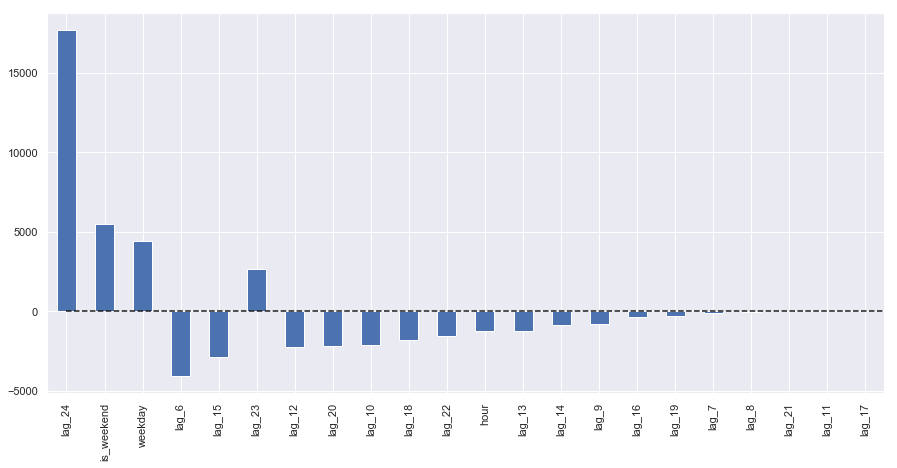

In [278]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)


[11:23:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


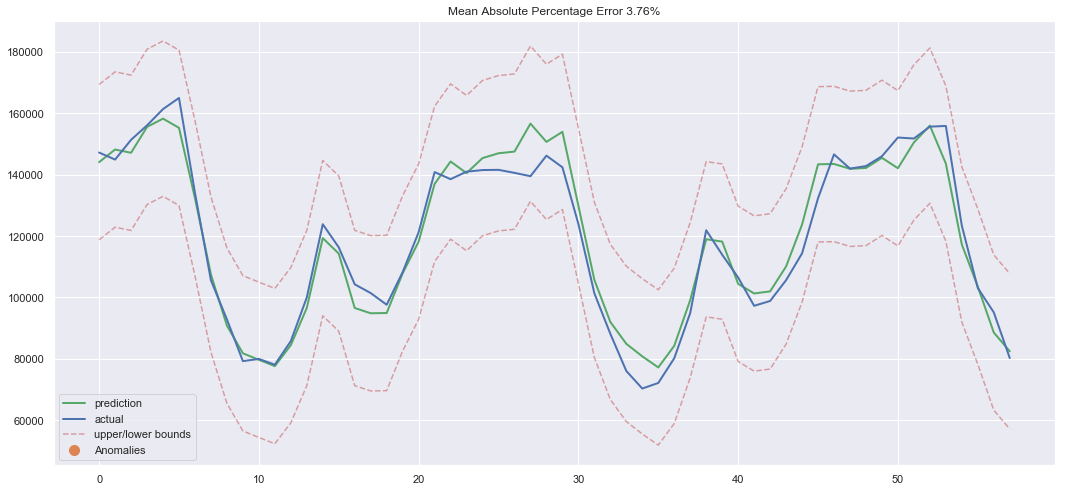

In [279]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)